In [11]:
import os
import itertools
import warnings
from datetime import datetime as dt

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

warnings.filterwarnings("ignore")

In [12]:
def generate_data_summary(raw_df):
    # Generate a summary for the raw data
    summary = raw_df.describe(include='all')
    summary.loc['type'] = raw_df.dtypes
    summary.loc['median'] = (raw_df.median() * 10000 // 100 / 100)
    summary.loc['mean'] = (raw_df.mean() * 10000 // 100 / 100)
    summary.loc['mode'] = raw_df.mode().iloc[0]
    summary.loc['missing'] = (
        (100.0 * raw_df.isna().sum() / len(raw_df)).round(2).astype(str) + '%')
    summary.loc['unique'] = raw_df.nunique()
    summary.loc['min'] = raw_df.min()
    summary.loc['max'] = raw_df.max()

    columns_order = ['type', 'count', 'missing', 'unique', 'min',
                     '25%', '50%', '75%', 'max', 'mean', 'median', 'std', 'mode']
    summary = summary.loc[columns_order].round(2)
    return summary


def find_missing_ranges(series):
    # Find the ranges of missing values in the series
    is_missing = series.isna()
    changes = is_missing.ne(is_missing.shift()).cumsum()
    missing_ranges = is_missing.groupby(changes).apply(
        lambda x: (x.index[0], x.index[-1]))
    return missing_ranges


def plot_time_series(ts1, ts2, ts1_label='Time Series 1', ts2_label='Time Series 2', figsize=(12, 10)):
    # Plot two time series on separate subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot the first time series
    axes[0].plot(ts1)
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Price')
    axes[0].set_title(ts1_label)

    # Plot the second time series
    axes[1].plot(ts2)
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Price')
    axes[1].set_title(ts2_label)

    # Show the plots
    plt.show()
    save_plot('ts1_ts2', f'Series Plots')


def save_plot(title, plot_name, fig=None):
    if not fig:
        fig = plt.gcf()

    # Create the EDA directory if it doesn't exist
    if not os.path.exists('Pre_processing'):
        os.makedirs('Pre_processing')

    # Create the subdirectory for the series if it doesn't exist
    series_path = f'Pre_processing/{title}'
    if not os.path.exists(series_path):
        os.makedirs(series_path)

    # Save the plot in the corresponding subdirectory with the plot_name in the file name
    fig.savefig(f'{series_path}/{plot_name}.png')
    plt.close()


def count_missing_values(series):
    return series.isna().sum()


def max_missing_range(series):
    mask = series.isna()
    changes = mask.ne(mask.shift()).cumsum()
    counts = mask.groupby(changes).sum()
    counts = counts[counts > 1]
    return 0 if counts.empty else counts.max()


def intervals_to_days(intervals):
    minutes = intervals * 2
    hours = minutes / 60
    days = hours / 24
    return days


def count_days_frequency(series):
    series = series.dropna()
    day_of_week_series = pd.Series(series.index.dayofweek, index=series.index)
    day_counts = day_of_week_series.value_counts().sort_index()
    day_counts.index = pd.to_datetime(
        day_counts.index, unit='D', origin=pd.Timestamp('2000-01-03')).day_name()
    return day_counts


def plot_streak_histogram(ts, title):
    isnull = ts.isnull()
    groups = isnull.ne(isnull.shift()).cumsum()
    streak_lengths = isnull.groupby(groups).sum()

    bins = pd.cut(streak_lengths, bins=[0, 1, 2, 3, 4, 5, 10, 100, 1000, streak_lengths.max()],
                  labels=[str(x*2) + ' mins' for x in range(1, 6)] + ['22 mins', '4 hours', '1.3 days', '4+ days'])
    plt.figure(figsize=(8, 7))
    # plot histogram of binned data
    ax = bins.value_counts().sort_index().plot(kind='bar', edgecolor='black')
    plt.title(title)
    # add values to bars
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() /
                    2, p.get_height()), ha='center', va='bottom')
    # show the plot
    save_plot(title, f'Missing Values Streaks Histogram_{title}')


def calculate_time_gaps(ts):
    isnull = ts.isnull()
    groups = isnull.ne(isnull.shift()).cumsum()
    streak_lengths = isnull.groupby(groups).sum()
    time_gaps = pd.to_timedelta(
        streak_lengths[streak_lengths > 0] * 2, unit='m')
    return time_gaps


def time_gaps_stats(series):
    return (series.dt.total_seconds() / 60).describe()


def rolling_mean(series, window=120):
    # Check if there are any missing values in the input series
    if series.isnull().any():
        # Create a copy of the input series for imputation
        imputed_series = series.copy()

        # Identify non-missing value blocks in the input series
        non_missing_blocks = series.notna().astype(int).groupby(
            series.isna().astype(int).cumsum()).cumsum()

        # Iterate through each non-missing value block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)

            # Calculate rolling mean for the block
            rolling_mean_block = series[start_idx:end_idx].rolling(
                window=window, min_periods=1).mean()

            # Impute missing values in the block with rolling mean
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(
                rolling_mean_block)

        # Fill any remaining missing values using backfill method
        imputed_series.fillna(method='bfill', inplace=True)
    else:
        # If there are no missing values, return the original series
        imputed_series = series
    return imputed_series


def rolling_median(series, window=120):
    # Check if there are any missing values in the input series
    if series.isnull().any():
        # Create a copy of the input series for imputation
        imputed_series = series.copy()

        # Identify non-missing value blocks in the input series
        non_missing_blocks = series.notna().astype(int).groupby(
            series.isna().astype(int).cumsum()).cumsum()

        # Iterate through each non-missing value block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)

            # Calculate rolling mean for the block
            rolling_mean_block = series[start_idx:end_idx].rolling(
                window=window, min_periods=1).median()

            # Impute missing values in the block with rolling mean
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].fillna(
                rolling_mean_block)

        # Fill any remaining missing values using backfill method
        imputed_series.fillna(method='bfill', inplace=True)
    else:
        # If there are no missing values, return the original series
        imputed_series = series
    return imputed_series


def impute_missing_values_mean(data, short_gap_threshold=120, long_gap_threshold=2880):
    # Identify the size of missing value gaps in the input data
    missing_gaps = data.isna().astype(int).groupby(
        data.notna().astype(int).cumsum()).cumsum()

    # Impute missing values for short gaps
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <=
                    short_gap_threshold] = rolling_mean(data_short_gaps)

    # Impute missing values for long gaps
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps > short_gap_threshold] = rolling_mean(
        data_long_gaps, long_gap_threshold)

    # Combine the short and long gap imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)

    # Fill any remaining missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)
    data_imputed.fillna(method='ffill', inplace=True)

    return data_imputed


def impute_missing_values_median(data, short_gap_threshold=120, long_gap_threshold=2880):
    # Identify the size of missing value gaps in the input data
    missing_gaps = data.isna().astype(int).groupby(
        data.notna().astype(int).cumsum()).cumsum()

    # Impute missing values for short gaps
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <=
                    short_gap_threshold] = rolling_median(data_short_gaps)

    # Impute missing values for long gaps
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps > short_gap_threshold] = rolling_median(
        data_long_gaps, long_gap_threshold)

    # Combine the short and long gap imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)

    # Fill any remaining missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)
    data_imputed.fillna(method='ffill', inplace=True)

    return data_imputed


def impute_missing_values_lin(data, short_gap_threshold=120):
    # Identify the size of missing value gaps in the input data
    missing_gaps = data.isna().astype(int).groupby(
        data.notna().astype(int).cumsum()).cumsum()

    # Impute missing values for short gaps using linear interpolation
    data_short_gaps = data.copy()
    data_short_gaps[missing_gaps <= short_gap_threshold] = linear_interpolation(
        data_short_gaps)

    # Impute missing values for long gaps using linear interpolation
    data_long_gaps = data.copy()
    data_long_gaps[missing_gaps >
                   short_gap_threshold] = linear_interpolation(data_long_gaps)

    # Combine the short and long gap imputed data
    data_imputed = data_short_gaps.combine_first(data_long_gaps)

    # Fill any remaining missing values using backfill and forward fill methods
    data_imputed.fillna(method='bfill', inplace=True)
    data_imputed.fillna(method='ffill', inplace=True)

    return data_imputed


def linear_interpolation(series):
    # Check if there are any missing values in the input series
    if series.isnull().any():
        # Create a copy of the input series for imputation
        imputed_series = series.copy()

        # Identify non-missing value blocks in the input series
        non_missing_blocks = series.notna().astype(int).groupby(
            series.isna().astype(int).cumsum()).cumsum()

        # Iterate through each non-missing value block
        for _, block in non_missing_blocks.groupby(non_missing_blocks):
            start_idx = block.index[0]
            end_idx = block.index[-1] + pd.Timedelta(minutes=2)

            # Impute missing values in the block using linear interpolation
            imputed_series[start_idx:end_idx] = series[start_idx:end_idx].interpolate(
                method='linear')

        # Fill any remaining missing values using backfill method
        imputed_series.fillna(method='bfill', inplace=True)
    else:
        # If there are no missing values, return the original series
        imputed_series = series
    return imputed_series


def load_data(filename):
    raw_df = pd.read_csv(filename, header=None)
    raw_df.columns = ['datetime', 'ts1', 'ts2']
    raw_df['datetime'] = pd.to_datetime(
        raw_df['datetime']-719529, unit='d').round('s')
    raw_df.set_index('datetime', inplace=True)
    return raw_df


def generate_data_summary(df):
    print(df.describe())


def analyze_time_gaps(df):
    time_gaps = df.index.to_series().diff().dropna()
    time_gap_stats = time_gaps.describe()
    print('Time gaps:\n')
    print(time_gap_stats)
    outlier_threshold = pd.Timedelta(minutes=10)
    outliers = time_gaps[time_gaps > outlier_threshold]
    plt.hist(time_gaps.dt.total_seconds() / 60, bins=50)
    plt.xlabel('Time Gap (minutes)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Gaps')
    plt.show()


def remove_weekends(df):
    # Remove rows corresponding to weekends (Saturday and Sunday)
    return df[df.index.dayofweek != 5]


def time_gaps_stats(s):
    return s.describe()


def count_days_frequency_resampled(ts):
    day_counts = count_days_frequency(ts.resample('D').mean())
    return day_counts


def data_pre_process(raw_df):
    # Generate data summary
    generate_data_summary(raw_df)

    # Define the time series
    ts1 = raw_df['ts1']
    ts2 = raw_df['ts2']

    # Analyze missing values and missing ranges
    analyze_missing_values(ts1, "ts1")
    analyze_missing_values(ts2, "ts2")

    # Analyze time gaps
    analyze_time_gaps(raw_df)

    # Count days frequency
    day_counts_ts1 = count_days_frequency_resampled(ts1)
    print(day_counts_ts1)

    day_counts_ts2 = count_days_frequency_resampled(ts2)
    print(day_counts_ts2)

    # Analyze missing values and missing ranges for non-smoothed data
    ts_1_ns = raw_df_ns['ts1']
    ts_2_ns = raw_df_ns['ts2']
    analyze_missing_values(ts1, "ts1")
    analyze_missing_values(ts2, "ts2")

    # Plot the histogram of missing value streaks for ts1_ns and ts2_ns
    plot_streak_histogram(ts1, 'ts1')
    plot_streak_histogram(ts2, 'ts2')

    # Analyze time gaps for non-smoothed data
    time_gaps_1 = calculate_time_gaps(ts1)
    print(time_gaps_stats(time_gaps_1))
    time_gaps_2 = calculate_time_gaps(ts2)
    print(time_gaps_stats(time_gaps_2))


def analyze_missing_values(ts, ts_name):
    missing_ts = count_missing_values(ts)
    print(f"Missing values in {ts_name}: {missing_ts}")

    max_ts = max_missing_range(ts)
    print(f"Max missing range in {ts_name}: {max_ts}")

    days_ts = intervals_to_days(max_ts)
    print(f"Max missing range in {ts_name}: {days_ts:.2f} days")


def analyze_time_gaps(df):
    time_gaps = df.index.to_series().diff().dropna()
    time_gap_stats = time_gaps.describe()
    print('Time gaps:\n')
    print(time_gap_stats)
    # plot_time_gaps_histogram(time_gaps)


def plot_time_gaps_histogram(time_gaps):
    outlier_threshold = pd.Timedelta(minutes=10)
    outliers = time_gaps[time_gaps > outlier_threshold]
    plt.hist(time_gaps.dt.total_seconds() / 60, bins=50)
    plt.xlabel('Time Gap (minutes)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Time Gaps')
    plt.show()


def count_days_frequency_resampled(ts):
    return count_days_frequency(ts.resample('D').mean())


def process_and_plot_time_series(raw_df, ts1_label='ts1', ts2_label='ts2', method='interpolate'):
    # Extract time series from the raw DataFrame
    ts1 = raw_df[ts1_label]
    ts2 = raw_df[ts2_label]

    # Plot the original time series
    plot_time_series(ts1, ts2, ts1_label, ts2_label)

    # Calculate maximum missing ranges for each time series
    max_ts1 = max_missing_range(ts1)
    max_ts2 = max_missing_range(ts2)

    if method == 'interpolate':
        # Impute missing values in ts1 and ts2 using linear interpolation
        imputed_ts1 = impute_missing_values_lin(ts1)
        imputed_ts2 = impute_missing_values_lin(ts2)
    elif method == 'mean':
        # Impute missing values in ts1 and ts2 using their respective maximum missing ranges
        imputed_ts1 = impute_missing_values_mean(
            ts1, long_gap_threshold=max_ts1)
        imputed_ts2 = impute_missing_values_mean(
            ts2, long_gap_threshold=max_ts2)
    elif method == 'median':
        # Impute missing values in ts1 and ts2 using their respective maximum missing ranges
        imputed_ts1 = impute_missing_values_median(
            ts1, long_gap_threshold=max_ts1)
        imputed_ts2 = impute_missing_values_median(
            ts2, long_gap_threshold=max_ts2)

    # Print the number of missing values in the imputed series
    print(f"Missing values in imputed {ts1_label}: {imputed_ts1.isna().sum()}")
    print(f"Missing values in imputed {ts2_label}: {imputed_ts2.isna().sum()}")

    # Calculate the maximum missing range in the imputed series
    max_imputed_ts1 = max_missing_range(imputed_ts1)
    max_imputed_ts2 = max_missing_range(imputed_ts2)

    # Print the maximum missing range in the imputed series
    print(f"Max missing range in imputed {ts1_label}: {max_imputed_ts1}")
    print(f"Max missing range in imputed {ts2_label}: {max_imputed_ts2}")

    # Plot the imputed time series
    plot_time_series(imputed_ts1, imputed_ts2,
                     f"Imputed {ts1_label}", f"Imputed {ts2_label}")
    clean_df = pd.concat([imputed_ts1, imputed_ts2], axis=1)
    return clean_df

def main():
    # Load the data
    filename = "Test_data.csv"
    raw_df = load_data(filename)
    raw_df.to_csv('raw_df.csv')
    # Perform the analysis excluding saturdays
    raw_df_ns = raw_df.copy()
    raw_df_ns = raw_df_ns[raw_df_ns.index.dayofweek != 5]  # 5 represents Saturday
    # Run the main function
    data_pre_process(raw_df) 
    data_pre_process(raw_df_ns)
    #impute missing values
    # imputation_methods = ['interpolate', 'mean', 'median']
    imputation_methods = ['interpolate']
    for method in imputation_methods:
        clean_df = process_and_plot_time_series(raw_df, ts1_label='ts1', ts2_label='ts2', method=method)
        clean_df.to_csv(f'{method}_imputed_df.csv')
        
if __name__ == "__main__":
    main()

                 ts1            ts2
count  201517.000000  936488.000000
mean       95.172272       0.927215
std         1.282164       0.119920
min        91.512942       0.601150
25%        95.106221       0.871450
50%        95.462056       0.945000
75%        96.042938       1.027800
max        96.852863       1.108050
Missing values in ts1: 1113924
Max missing range in ts1: 3579
Max missing range in ts1: 4.97 days
Missing values in ts2: 378953
Max missing range in ts2: 2139
Max missing range in ts2: 2.97 days
Time gaps:

count            1315440
mean     0 days 00:02:00
std      0 days 00:00:00
min      0 days 00:02:00
25%      0 days 00:02:00
50%      0 days 00:02:00
75%      0 days 00:02:00
max      0 days 00:02:00
Name: datetime, dtype: object
Monday       258
Tuesday      259
Wednesday    261
Thursday     260
Friday       253
Sunday       243
Name: datetime, dtype: int64
Monday       261
Tuesday      262
Wednesday    261
Thursday     261
Friday       260
Sunday       259
Name: 

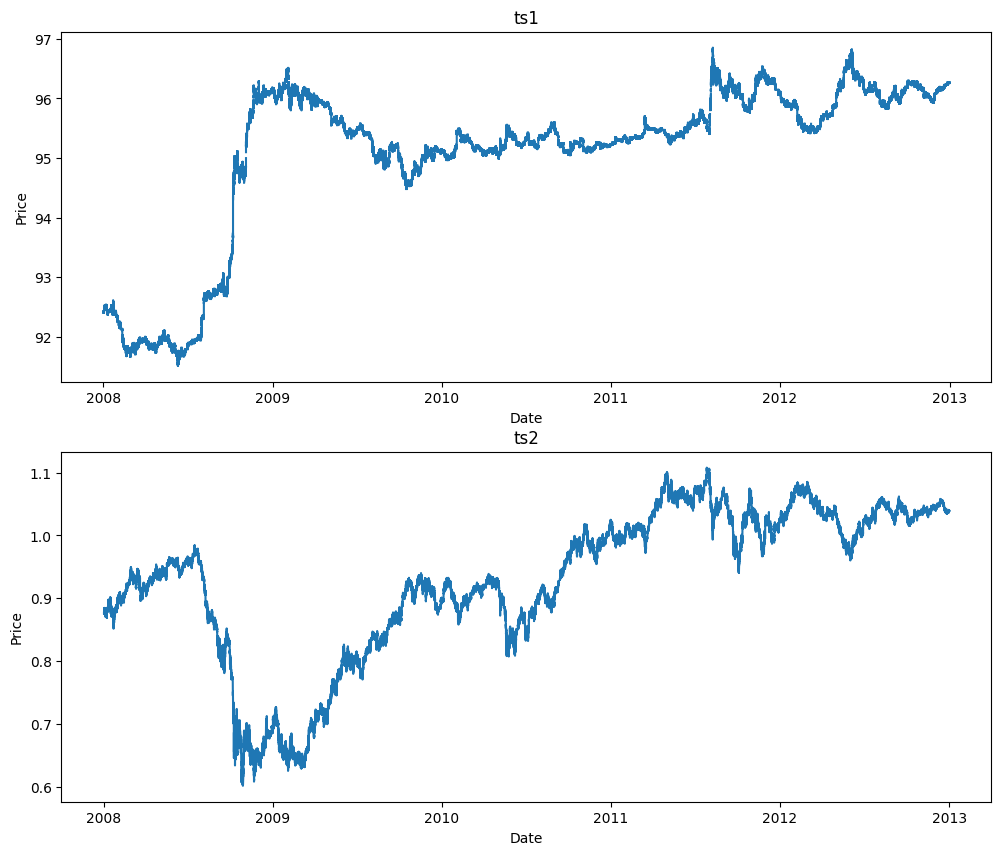

KeyboardInterrupt: 